# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at mlta-2023-spring@googlegroups.com



## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

In [17]:
!apt update
!apt install python-opengl xvfb -y
!pip install -q swig
!pip install box2d==2.3.2 gym[box2d]==0.25.2 box2d-py pyvirtualdisplay tqdm numpy==1.22.4
!pip install box2d==2.3.2 box2d-kengz
!pip freeze > requirements.txt


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
21 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
R


Next, set up virtual display，and import all necessaary packages.

In [18]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [19]:
seed = 2023 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [20]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment".

In this homework, we will utilize the function `step()` to control the action of "Agent".

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [21]:
print(env.observation_space)

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [22]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment.
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [23]:
initial_state = env.reset()
print(initial_state)

[-0.00506535  1.413064   -0.5130838   0.09527162  0.00587628  0.11622101
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [24]:
random_action = env.action_space.sample()
print(random_action)

1


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [25]:
observation, reward, done, info = env.step(random_action)

In [26]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points.

In [27]:
print(reward)

-1.4981841929643156


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

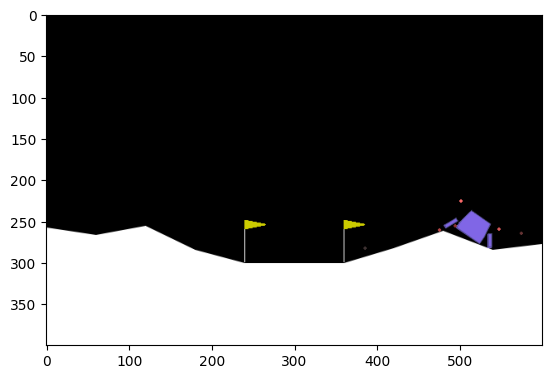

In [28]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Policy Gradient
Now, we can build a simple policy network. The network will return one of action in the action space.

In [29]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(hid)
        return F.softmax(self.fc3(hid), dim=-1)

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities.

In [34]:
from collections import namedtuple

class ReplayMemory:
    """Fixed-size buffer to store experience tuples."""
    def __init__(self, CAPACITY):
        self.capacity = CAPACITY
        self.memory = []
        self.index = 0
        self.transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

    def push(self, state, action, state_next, reward):
        """Push a new experience to memory."""
        if len(self.memory) < self.capacity: # if still has capacity, initialize memory[index] to None
            self.memory.append(None)

        self.memory[self.index] = self.transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity  # circular index

    def sample(self, batch_size):
        """Randomly sample a batch of experiences from memory."""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

class DQN(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size=8, action_size=4, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent():
    """Interacts with and learns from the environment."""
    def __init__(self, num_states, num_actions):
        """Initialize an Agent object."""

        self.num_states = num_states
        self.num_actions = num_actions

        # Replay memory
        self.memory_capacity = 10000
        self.memory = ReplayMemory(self.memory_capacity)

        # Q-Network
        self.main_q_network = DQN()
        self.target_q_network = DQN()

        # optimizer
        self.optimizer = optim.RMSprop(self.main_q_network.parameters(), lr=1e-4)

    def update_q_function(self):
        '''update q function'''

        # no enough samples, just return
        if len(self.memory) < BATCH_SIZE:
            return
        # If enough samples are available in memory, get random subset and learn
        self.batch, self.state_batch, self.action_batch, self.reward_batch, self.non_final_next_states = self.make_minibatch()

        self.expected_state_action_values = self.get_expected_state_action_values()

        self.update_main_q_network()

    def make_minibatch(self):
        '''Creating a mini-batch'''

        transitions = self.memory.sample(BATCH_SIZE)

        Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
        batch = Transition(*zip(*transitions))


        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])

        return batch, state_batch, action_batch, reward_batch, non_final_next_states

    def get_expected_state_action_values(self):
        '''calculate Q（St,at）'''

        self.main_q_network.eval()
        self.target_q_network.eval()

        self.state_action_values = self.main_q_network(
            self.state_batch).gather(1, self.action_batch)

        non_final_mask = torch.BoolTensor(tuple(map(lambda s: s is not None,
                                                    self.batch.next_state)))
        # set all state to 0
        next_state_values = torch.zeros(BATCH_SIZE)

        next_state_values[non_final_mask] = self.target_q_network(
            self.non_final_next_states).max(1)[0].detach()
        # DQN formula
        expected_state_action_values = self.reward_batch + GAMMA * next_state_values

        return expected_state_action_values

    def get_action(self, state, episode, test=False):
        """Returns actions for given state as per current policy."""
        if test:
            self.main_q_network.eval()
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action = self.main_q_network(torch.from_numpy(state).unsqueeze(0)).max(1)[1].view(1, 1)
            return action.item()

        global steps_done
        # Epsilon-greedy policy
        #epsilon = episode
        #epsilon = 0.5 * (1 / (episode + 1))
        epsilon = EPS_END + (EPS_START - EPS_END) * \
                np.exp(-1. * steps_done / EPS_DECAY)
        #print('epsilon', epsilon)

        steps_done += 1

        if epsilon <= np.random.uniform(0, 1):
            #print('use max')
            self.main_q_network.eval()
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action = self.main_q_network(state).max(1)[1].view(1, 1)
        else:
            #print('random')
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])

        return action

    def update_main_q_network(self):

        '''update main q net'''

        # set train mode
        self.main_q_network.train()
        # Hurberloss function
        # expected_state_action_values (minbatch,)->(minbatchx1)

        loss = F.smooth_l1_loss(self.state_action_values,
                                self.expected_state_action_values.unsqueeze(1))

        # update
        self.optimizer.zero_grad()  # reset gradient
        loss.backward()  # backpropagation
        for param in self.main_q_network.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()  # update network


    def memorize(self, state, action, state_next, reward):
        '''save state, action, state_next, reward into replay memory'''
        self.memory.push(state, action, state_next, reward)

    def update_target_q_function(self):

        '''synchronize Target Q-Network to Main Q-Network'''
        self.target_q_network.load_state_dict(self.main_q_network.state_dict())
'''
class Action(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(8, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, 4)

  def forward(self, state):
      hid = torch.tanh(self.fc1(state))
      hid = torch.tanh(self.fc2(hid))
      return F.softmax(self.fc3(hid), dim=-1)
class Critic(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(8, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, 4)

  def forward(self, state):
      hid = torch.tanh(self.fc1(state))
      hid = torch.tanh(self.fc2(hid))
      return F.softmax(self.fc3(hid), dim=-1)

from torch.optim.lr_scheduler import StepLR
class DQN():
    def __init__(self,action,critic):
        self.action_net = action
        self.critic_net = critic
        self.optimizer = optim.Adam(self.action_net.parameters(), lr=5e-4)
        self.critic_net.load_state_dict(self.action_net.state_dict()) # 加载action_net的行为
        self.critic_net.eval() # 模型验证
    def forward(self, state):
        return self.action_net(state)
    def learn(self, state_action_values, expected_state_action_values,batch):
        loss = torch.zeros(1)
        for i in range(len(state_action_values)):
            loss += F.smooth_l1_loss(state_action_values[i], expected_state_action_values[i])
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # 每10个batch更新一次target_net
        if batch%10 == 9:
            self.critic_net.load_state_dict(self.action_net.state_dict())
    def sample(self, state):
        r = torch.randn(1)
        if r > 0.2:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                return self.action_net(state).argmax().item()
        else:
            return torch.tensor([[random.randrange(4)]], device=device, dtype=torch.long).item()
'''
'''
from torch.optim.lr_scheduler import StepLR
class PolicyGradientAgent():

    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.002)

    def forward(self, state):
        return self.network(state)
    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob
'''

"\nfrom torch.optim.lr_scheduler import StepLR\nclass PolicyGradientAgent():\n    \n    def __init__(self, network):\n        self.network = network\n        self.optimizer = optim.SGD(self.network.parameters(), lr=0.002)\n        \n    def forward(self, state):\n        return self.network(state)\n    def learn(self, log_probs, rewards):\n        loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)\n\n        self.optimizer.zero_grad()\n        loss.backward()\n        self.optimizer.step()\n        \n    def sample(self, state):\n        action_prob = self.network(torch.FloatTensor(state))\n        action_dist = Categorical(action_prob)\n        action = action_dist.sample()\n        log_prob = action_dist.log_prob(action)\n        return action.item(), log_prob\n"

Lastly, build a network and agent to start training.

In [35]:
#network = PolicyGradientNetwork()
#agent = PolicyGradientAgent(network)
#network = DQN()
agent = DQNAgent(num_states=8,num_actions=4)

## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

In [ ]:
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 600        # 總共更新 400 次
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

best_score = 0
best_batch = 0
agent.main_q_network.train()
agent.target_q_network.train()
steps_done = 0

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    rewards = []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):

        observation = env.reset() # 環境的初始化
        state = observation  # 將觀測結果直接當成狀態s使用
        state = torch.from_numpy(state).type(
                torch.FloatTensor)  # 將NumPy變數轉換成PyTorch的張量
        state = torch.unsqueeze(state, 0)  # 將size 4轉換成size 1x4
        total_reward, total_step = 0, 0

        while True:

            action = agent.get_action(state, batch)  # 求出動作
            # 執行動作a_t後，算出s_{t+1}與done旗標
            # 根據action指定.item()、再取得內容
            observation_next, reward, done, _ = env.step(action.item())  # 不會用到info，所以設定為_

            total_reward += reward
            total_step += 1
            rewards.append(reward) #改這裡
            # ! 重要 ！
            # 現在的reward 的implementation 為每個時刻的瞬時reward, 給定action_list : a1, a2, a3 ......
            #                                                       reward :     r1, r2 ,r3 ......
            # medium：將reward調整成accumulative decaying reward, 給定action_list : a1,                         a2,                           a3 ......
            #                                                       reward :     r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,r3+0.99*r4+0.99^2*r5+ ......
            # boss : implement DQN
            if done:
                state_next = None  # 沒有下個狀態，所以存入None

            else:
                state_next = observation_next  # 直接將觀測結果當成狀態使用
                state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)  # 將numpy變數轉換成PyTorch的張量
                state_next = torch.unsqueeze(state_next, 0)  # 將size 4轉換成size 1x4

            # 將學習經驗存入記憶體
            agent.memorize(state, action, state_next, torch.FloatTensor([reward]))

            # 以Experience Replay更新Q函數
            agent.update_q_function()

            # 觀測狀態的更新
            state = state_next

            # 結束時的處理
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break


    #print(f"rewards looks like ", np.shape(rewards))
    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    # rewards = np.concatenate(rewards, axis=0)
    #rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    agent.update_target_q_function()
    print("torch.from_numpy(rewards) looks like ", torch.from_numpy(np.array(rewards)).size())


    ### testing

    fix(env, seed)
    agent.main_q_network.eval()  # 測試前先將 network 切換為 evaluation 模式
    NUM_OF_TEST = 5 # Do not revise it !!!!!
    test_total_reward = []
    action_list = []
    for i in range(NUM_OF_TEST):
        actions = []
        state = env.reset()

        #img = plt.imshow(env.render(mode='rgb_array'))

        total_reward = 0

        done = False
        while not done:
            action = agent.get_action(state, episode=i, test=True)
            actions.append(action)
            state, reward, done, _ = env.step(action)

            total_reward += reward

            #img.set_data(env.render(mode='rgb_array'))
            #display.display(plt.gcf())
            #display.clear_output(wait=True)
        print(total_reward)
        test_total_reward.append(total_reward)

        action_list.append(actions) #儲存你測試的結果
        print("length of actions is ", len(actions))
    print(f"Your final reward is : %.2f"%np.mean(test_total_reward))
    if np.mean(test_total_reward) > 250:
        distribution = {}
        for actions in action_list:
            for action in actions:
                if action not in distribution.keys():
                    distribution[action] = 1
                else:
                    distribution[action] += 1
        PATH = "Action_List_test" + str(batch) + ".npy" # 可以改成你想取的名字或路徑
        np.save(PATH ,np.array(action_list))
        if np.mean(test_total_reward) > best_score:
            best_score = np.mean(test_total_reward)
            best_batch = batch
            print('Improve to score %.2f at batch %d'% (best_score, best_batch ))
'''
agent.action_net.train()  # 訓練前，先確保 network 處在 training 模式
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 600        # 總共更新 400 次
avg_total_rewards, avg_final_rewards = [], []
prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:
    state_action_values, expected_state_action_values = [], []
    total_rewards, final_rewards = [], []
    # 收集训练资料
    for episode in range(EPISODE_PER_BATCH):
        state = env.reset()
        total_reward = 0
        while True:
            action = agent.sample(state)
            next_state, reward, done, _ = env.step(action)
            state_action_value = agent.action_net(torch.FloatTensor(state).to(device))[action]
            state_action_values.append(state_action_value)
            state = next_state
            #Double DQN
            if done:
                next_state_value = 0
            else:
                next_state_value = agent.critic_net(torch.FloatTensor(state).to(device))[agent.action_net(torch.FloatTensor(state).to(device)).argmax().item()].detach()
            # 使用Policy Gradient
            expected_state_action_value = (next_state_value * 0.99) + reward
            expected_state_action_values.append(torch.FloatTensor([expected_state_action_value]))
            total_reward += reward
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break

    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")
    # print(expected_state_action_values)
    # 更新網路
    agent.learn(state_action_values, expected_state_action_values, batch)

'''
'''
agent.network.train()  # Switch network into training mode
EPISODE_PER_BATCH = 5  # update the  agent every 5 episode
NUM_BATCH = 500        # totally update the agent for 400 time

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # collect trajectory
    for episode in range(EPISODE_PER_BATCH):

        state = env.reset()
        total_reward, total_step = 0, 0
        seq_rewards = []
        while True:

            action, log_prob = agent.sample(state) # at, log(at|st)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
            # seq_rewards.append(reward)
            state = next_state
            total_reward += reward
            total_step += 1
            rewards.append(reward) # change here
            n_reward = reward
            for i in range(len(rewards)-1):
              n_reward *= 0.99
              rewards[len(rewards)-2-i] += n_reward
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)

                break

    print(f"rewards looks like ", np.shape(rewards))
    print(f"log_probs looks like ", np.shape(log_probs))
    # record training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # update agent
    # rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # normalize the reward
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
    print("logs prob looks like ", torch.stack(log_probs).size())
    print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

'''
'''
agent.network.train()  # Switch network into training mode
EPISODE_PER_BATCH = 5  # update the  agent every 5 episode
NUM_BATCH = 100        # totally update the agent for 500 time

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # collect trajectory
    for episode in range(EPISODE_PER_BATCH):

        state = env.reset()
        total_reward, total_step = 0, 0
        seq_rewards = []
        while True:

            action, log_prob = agent.sample(state) # at, log(at|st)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
            # seq_rewards.append(reward)
            state = next_state
            total_reward += reward
            total_step += 1
            rewards.append(reward) # change here
            # ! IMPORTANT !
            # Current reward implementation: immediate reward,  given action_list : a1, a2, a3 ......
            #                                                         rewards :     r1, r2 ,r3 ......
            # medium：change "rewards" to accumulative decaying reward, given action_list : a1,                           a2,                           a3, ......
            #                                                           rewards :           r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,  r3+0.99*r4+0.99^2*r5+ ......
            # boss : implement Actor-Critic
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)

                break

    print(f"rewards looks like ", np.shape(rewards))
    #print(f"log_probs looks like ", np.shape(log_probs))
    # record training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # update agent
    # rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # normalize the reward
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
    print("logs prob looks like ", torch.stack(log_probs).size())
    print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())'''

  0%|          | 0/600 [00:00<?, ?it/s]

torch.from_numpy(rewards) looks like  torch.Size([400])
-169.24737767540185
length of actions is  76
-97.80035892867915
length of actions is  84
-108.21350771248544
length of actions is  79
-114.88630094034575
length of actions is  76
-152.81054267812647
length of actions is  65
Your final reward is : -128.59
torch.from_numpy(rewards) looks like  torch.Size([404])
-132.63278859406427
length of actions is  75
-229.09042071196592
length of actions is  76
-128.03044869662298
length of actions is  67
-219.0283692430635
length of actions is  71
-276.1757812058139
length of actions is  85
Your final reward is : -196.99
torch.from_numpy(rewards) looks like  torch.Size([354])
-143.89890076653535
length of actions is  75
-200.4439344759164
length of actions is  77
-218.03534750920863
length of actions is  93
-165.0825493357254
length of actions is  61
-136.19168681846264
length of actions is  60
Your final reward is : -172.73
torch.from_numpy(rewards) looks like  torch.Size([377])
-165.89831643

### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:


In [ ]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


In [ ]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## Testing
The testing result will be the average reward of 5 testing

In [ ]:
fix(env, seed)
agent.q_target.eval()
#agent.network.eval()  # set the network into evaluation mode
NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action, _ = agent.sample(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      img.set_data(env.render(mode='rgb_array'))
      display.display(plt.gcf())
      display.clear_output(wait=True)

  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) # save the result of testing


In [ ]:
print(np.mean(test_total_reward))

Action list

In [ ]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Analysis of actions taken by agent

In [ ]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

Saving the result of Model Testing


In [ ]:
PATH = "Action_List.npy" # Can be modified into the name or path you want
np.save(PATH ,np.array(action_list))

### This is the file you need to submit !!!
Download the testing result to your device



In [ ]:
from google.colab import files
files.download(PATH)

# Server
The code below simulate the environment on the judge server. Can be used for testing.

In [ ]:
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 2023 # Do not revise this
fix(env, seed)

agent.network.eval()  # set network to evaluation mode

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False

  for action in actions:

      state, reward, done, _ = env.step(action)
      total_reward += reward
      if done:
        break

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# Your score

In [ ]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
